В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, 
и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. 
Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. 
Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк!
Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-09-26' по '2022-10-02'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. 
На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [28]:
import pandas as pd
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from scipy import stats
%matplotlib inline

In [1]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20221020'
}

q = '''SELECT exp_group,
              user_id,
              sum(action = 'like') likes,
              sum(action = 'view') views,
              likes / views ctr
        FROM {db}.feed_actions 
        where toDate(time) between '2022-09-26' and '2022-10-02'
            and exp_group in (2,3)
        group by exp_group, user_id
     '''

In [30]:
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [4]:
df.groupby('exp_group')['user_id'].count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

In [5]:
sns.set(rc={'figure.figsize': (12,9)})

<AxesSubplot:xlabel='ctr', ylabel='Count'>

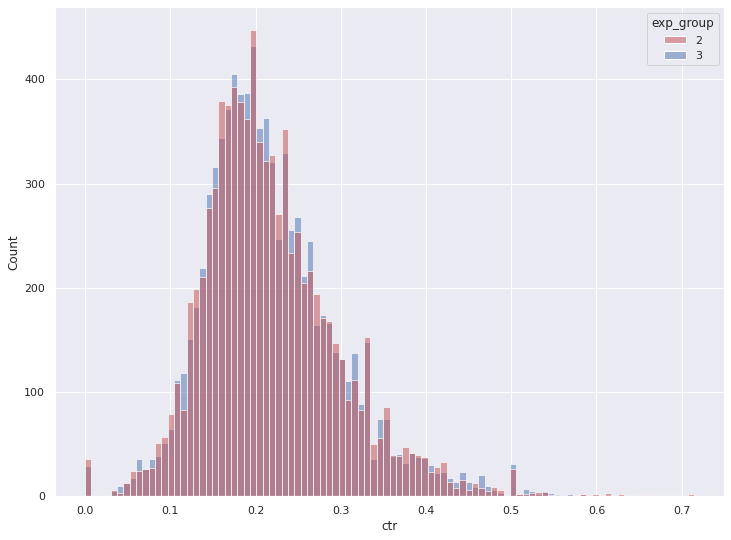

In [6]:
sns.histplot(data=df,
            x='ctr',
            hue='exp_group',
            palette=['r', 'b'],
            alpha=0.5,
            kde=False)

In [7]:
stats.ttest_ind(df[df['exp_group'] == 2]['ctr'],
               df[df['exp_group'] == 3]['ctr'],
               equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Нулевую гипотезу отклонить не можем т.е. альфа > 5%

Проведем симуляцию из 10 000 АА-тестов.

1. Сформируем подвыборки с повторением из 500 пользователей из каждой эспериментальной группы;
2. Проведем сравнение этих подвыборок t-testом 
3. Нулевая гипотеза - равенство средних CTR

In [ ]:
p_values = []
for _ in range(10000):
    gr_2 = df[df['exp_group'] == 2]['ctr'].sample(n=500, replace=True)
    gr_3 = df[df['exp_group'] == 3]['ctr'].sample(n=500, replace=True)    
    t, p = stats.ttest_ind(gr_2,
                           gr_3,
                           equal_var=False)
    p_values.append(p)

In [9]:
p_series = pd.Series(p_values)

<AxesSubplot:ylabel='Count'>

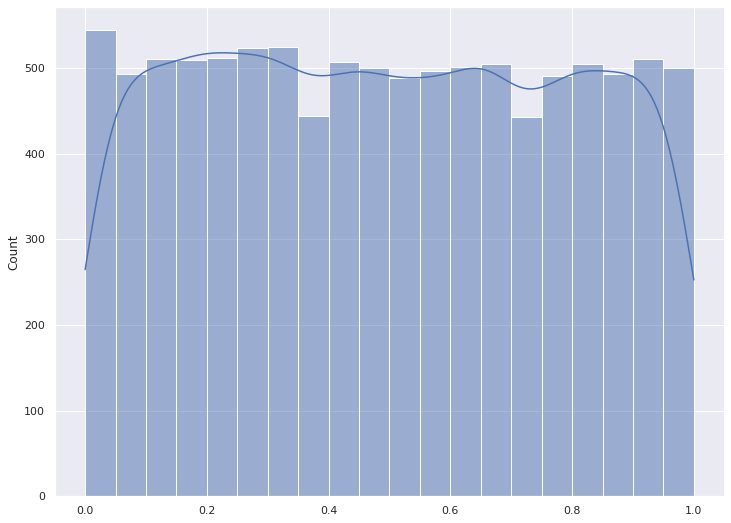

In [10]:
sns.histplot(data=p_series,
             bins= 20,
             kde=True)

In [11]:
# Процент p-value <= 5%
len(p_series[p_series <= 0.05]) / len(p_series) * 100

5.43

Повторим те же действия, но со сглашенным CTR

In [12]:
def smothed_ctr(user_likes, user_views, global_ctr, alpha):
    ctr_ = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return ctr_

In [13]:
global_ctr_1 = df[df['exp_group'] == 2]['likes'].sum() / df[df['exp_group'] == 2]['views'].sum()
global_ctr_2 = df[df['exp_group'] == 3]['likes'].sum() / df[df['exp_group'] == 3]['views'].sum()

In [14]:
df['smothed_ctr_1'] = df.apply(lambda x: smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr_1', ylabel='Count'>

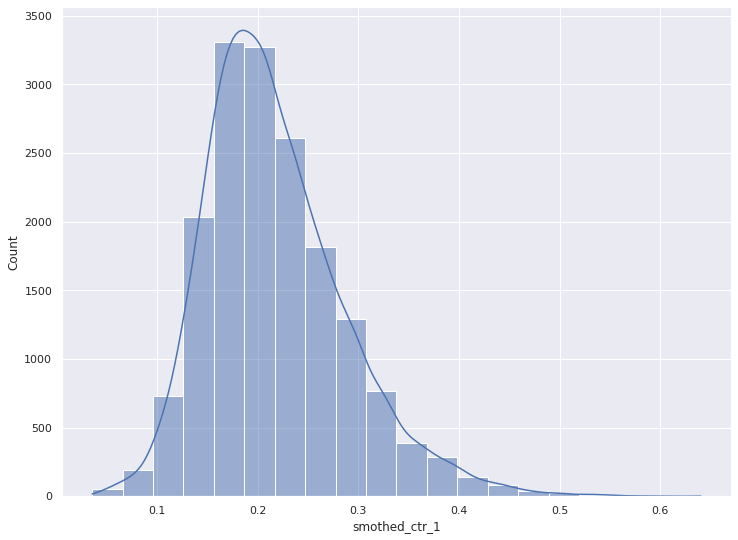

In [15]:
sns.histplot(data=df['smothed_ctr_1'],
             bins= 20,
             kde=True)

In [16]:
df['smothed_ctr_2'] = df.apply(lambda x: smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr_2', ylabel='Count'>

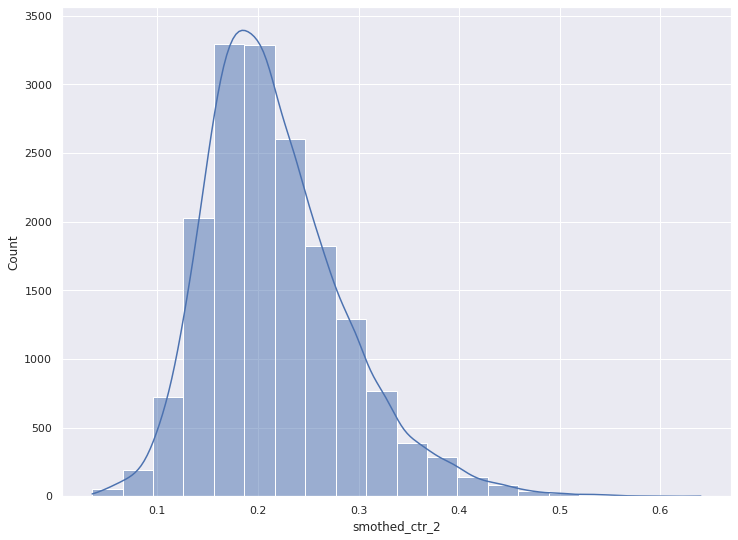

In [17]:
sns.histplot(data=df['smothed_ctr_2'],
             bins= 20,
             kde=True)

In [18]:
stats.ttest_ind(df[df['exp_group'] == 2]['smothed_ctr_1'],
               df[df['exp_group'] == 3]['smothed_ctr_2'],
               equal_var=False)

Ttest_indResult(statistic=-0.660314129929287, pvalue=0.5090611865557697)

In [19]:
p_values_s = []
for _ in range(10000):
    gr_2 = df[df['exp_group'] == 2]['smothed_ctr_1'].sample(n=500, replace=True)
    gr_3 = df[df['exp_group'] == 3]['smothed_ctr_2'].sample(n=500, replace=True)    
    t, p = stats.ttest_ind(gr_2,
                    gr_3,
                    equal_var=False)
    p_values_s.append(p)

In [20]:
p_series_s = pd.Series(p_values_s)

<AxesSubplot:ylabel='Count'>

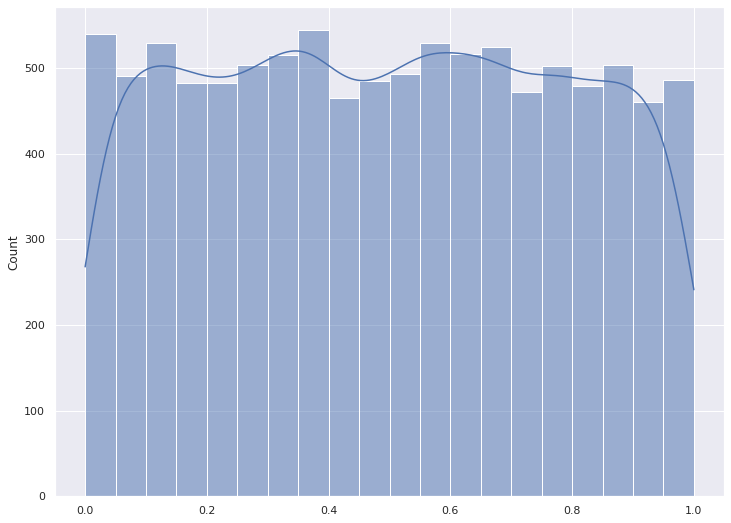

In [21]:
sns.histplot(data=p_series_s,
             bins= 20,
             kde=True)

In [22]:
# Процент p-value <= 5%
len(p_series_s[p_series_s <= 0.05]) / len(p_series_s) * 100

5.4

Выводы:

1. Распределение значений p-value - равномерное
2. В ~5% случаях p-values меньше либо равен 5%

АА-тест сошелся и что наша система сплитования работает корректно.